In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tensorboard

In [ ]:
from srthesis.utils import *
select_gpu()

GPUs:2
Selected GPU:2
Available memory:11005MB


In [ ]:
import shutil

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

import torch
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter

from srthesis.data import *
from srthesis.loss import *
from srthesis.metrics import *
from srthesis.callbacks import *
from srthesis.model import *



Setting up Perceptual loss...
Loading model from: /home/luslad/thesis/PerceptualSimilarity/models/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


# Config

In [ ]:
run_id = 'with_GAN_0'

In [ ]:
proj_id = 'base_model'

scale = 2

gen_name = run_id + '-gen'
pre_gen_name = gen_name + '_0'
crit_name =  run_id + '-crit'

name_gen = run_id + '-image_gen'
path_gen = path_dataset/name_gen

LOGGING_PATH = Path('data/logging/' + run_id)
TENSORBOARD_PATH = Path('data/tensorboard/' + run_id)


pct_start = 1e-8

In [ ]:
def delete_log_dir(path:str):
    shutil.rmtree(path, ignore_errors=True)
    
delete_log_dir(TENSORBOARD_PATH)
delete_log_dir(LOGGING_PATH)

# Data

In [ ]:
metrics = [AverageMetric(PSNR), AverageMetric(SSIM), AverageMetric(LPIPS)]

# Model

In [ ]:
bs,size=32,128

In [ ]:
wd = 1e-3
learn_gen = create_generator_learner(data)
gc.collect();

## Callbacks

### Save predicted image 

In [ ]:
imgs = np.array([image_for_prediction(idx) for idx in [0,1,16]])
save_img_cb = SaveTestImageCallback(learn_gen, LOGGING_PATH/"predictions", imgs)

### Tensorboard logger and CSV logger

In [ ]:
writer = SummaryWriter(log_dir = TENSORBOARD_PATH/'GenPre')

In [ ]:
tb_cb = ImageGenTensorboardWriter(learn_gen, writer, visual_iters=1)

In [ ]:
class CsvLoggerEx(CSVLogger):
    def __init__(self, learn:Learner, filename: str = 'history', append: bool = False): 
        super().__init__(learn, filename, append)
        self.path = LOGGING_PATH / filename

csv_logger = CsvLoggerEx(learn_gen, 'training_history.csv', True)

# Training

## Generator Pre-Training

In [ ]:
# testing metrics on dummy data
# dummy_data = get_dummy_data()
# learn_gen.data = dummy_data
# learn_gen.fit_one_cycle(2, 1e-3, pct_start=0.9, callbacks=[tb_cb])
# learn_gen.fit_one_cycle(3, 1e-3, pct_start=0.9, callbacks=[tb_cb])
# learn_gen.fit_one_cycle(5, 1e-3, pct_start=0.9, callbacks=[tb_cb])

### 32px → 64px

In [ ]:
data = get_data(64,bs=44)
learn_gen.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


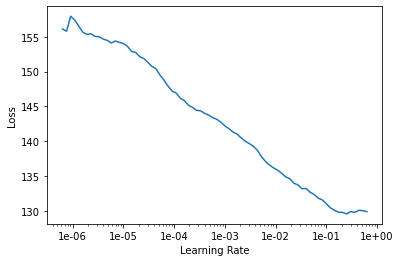

In [ ]:
learn_gen.lr_find()
learn_gen.recorder.plot()

In [ ]:
lr = 5e-3

In [ ]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):                                     
    learn_gen.fit_one_cycle(10, lrs, pct_start=pct_start, callbacks=[tb_cb, csv_logger]) #, save_img_cb])
    learn_gen.save(save_name)
    learn_gen.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
0,131.613419,127.087097,11.459517,0.187811,0.475233,0.933033,1.636798,2.654957,1.374135,00:26
1,123.689400,110.371925,15.383003,0.384379,0.220667,0.591246,1.386976,2.339114,1.228633,00:18
2,114.358612,96.678886,18.812082,0.567515,0.139266,0.379877,1.172060,2.012097,1.095125,00:18
3,106.303436,90.825233,19.630383,0.642145,0.096991,0.342385,1.074431,1.854257,1.061362,00:18
4,100.409859,86.451317,20.173983,0.685872,0.107713,0.317503,1.029180,1.751072,1.019576,00:19
5,95.874977,85.749710,20.483404,0.702349,0.103660,0.304256,1.007299,1.739626,1.021122,00:18
6,93.064987,84.844727,20.950233,0.723919,0.103075,0.282428,0.993591,1.704749,1.012501,00:19
7,90.636909,84.548363,20.555435,0.725421,0.096975,0.301807,0.984126,1.687940,0.999327,00:19
8,88.669632,80.690941,21.179348,0.739923,0.100339,0.266449,0.942741,1.614591,0.972748,00:18
9,89.010040,82.779755,21.082685,0.739013,0.100257,0.272761,0.965694,1.664477,0.993691,00:19


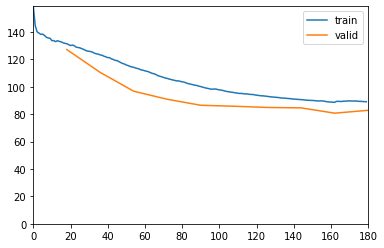

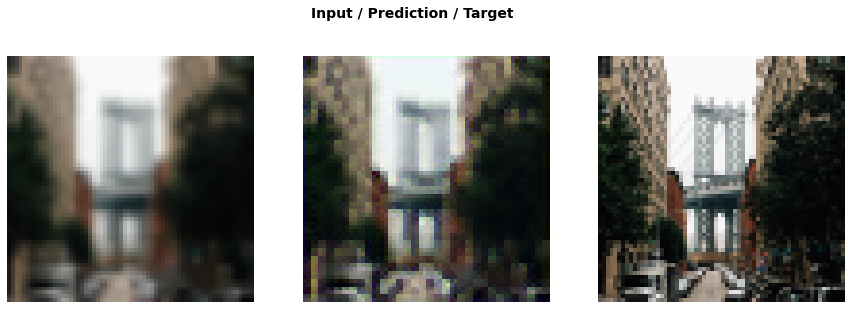

In [ ]:
do_fit('1a', slice(lr))

In [ ]:
learn_gen.unfreeze()

In [ ]:
#learn_gen.lr_find()
#learn_gen.recorder.plot()

epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
0,84.364769,81.810104,21.135517,0.739420,0.098372,0.272716,0.956741,1.647362,0.986123,00:18
1,83.944893,81.113136,21.199604,0.740360,0.094476,0.271224,0.946103,1.633211,0.982211,00:20
2,83.594330,80.415199,21.249628,0.741913,0.088664,0.268172,0.938579,1.619063,0.980062,00:19
3,82.872444,79.620178,21.293798,0.741367,0.083631,0.264605,0.930416,1.603242,0.975076,00:19
4,82.253105,79.129456,21.292601,0.742803,0.081682,0.265060,0.923682,1.593668,0.970068,00:19
5,81.582817,78.324417,21.347816,0.745457,0.079300,0.260923,0.918803,1.576627,0.961453,00:19
6,80.980774,77.884346,21.318720,0.740486,0.081627,0.264266,0.915455,1.570566,0.955903,00:19
7,80.889885,77.907578,21.416763,0.746690,0.085356,0.258179,0.911158,1.568804,0.951012,00:19
8,80.301506,76.856354,21.321917,0.745013,0.078095,0.260012,0.906613,1.553815,0.940892,00:18
9,79.922241,76.990578,21.373108,0.748113,0.079211,0.256946,0.904006,1.553124,0.942425,00:18


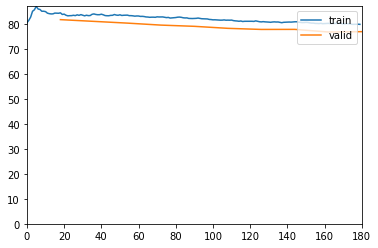

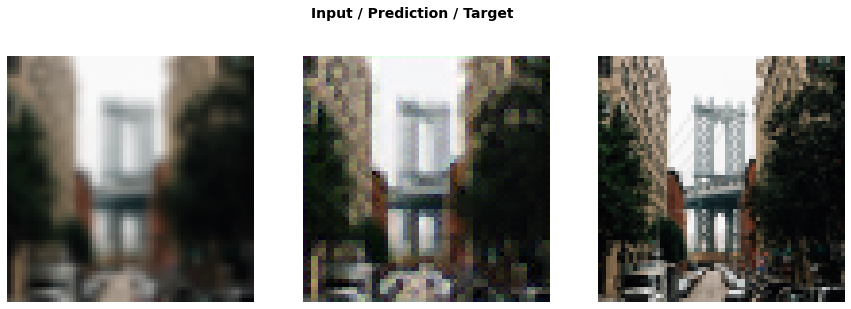

In [ ]:
do_fit('1b', slice(1e-6,5e-4))

### 64px → 128px

In [ ]:
data = get_data(128, bs=44)

In [ ]:
learn_gen.data = data
learn_gen.freeze()
gc.collect()

8600

In [ ]:
learn_gen.load('1b');

In [ ]:
#learn_gen.lr_find()
#learn_gen.recorder.plot()

epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
0,40.214588,39.276974,22.228350,0.756938,0.104506,0.220611,0.806591,1.200944,0.691160,00:33
1,40.145462,38.672203,22.155893,0.751879,0.092678,0.223526,0.805245,1.196742,0.683259,00:21
2,39.931858,38.811928,22.056179,0.750645,0.082848,0.228198,0.805256,1.200173,0.686819,00:20
3,39.853989,39.538067,22.361805,0.757351,0.106437,0.217147,0.811500,1.206422,0.682042,00:19
4,40.043423,38.839088,22.128613,0.753124,0.089962,0.223353,0.808371,1.205716,0.681744,00:19
5,40.587334,41.127934,21.086092,0.736868,0.111218,0.280520,0.838039,1.257666,0.702923,00:20
6,41.108307,41.295578,21.836998,0.734048,0.102166,0.245385,0.836201,1.256560,0.701317,00:20
7,41.210918,40.012482,22.210894,0.750928,0.101420,0.225486,0.813106,1.222404,0.689519,00:22
8,40.964970,39.312115,22.160345,0.753863,0.100791,0.224860,0.810484,1.207156,0.685225,00:20
9,40.572948,38.203297,22.072685,0.750245,0.089425,0.227165,0.799586,1.184714,0.676414,00:20


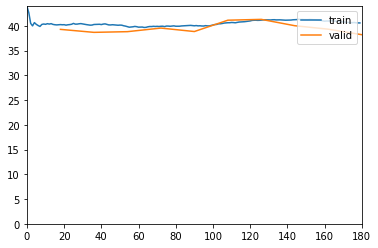

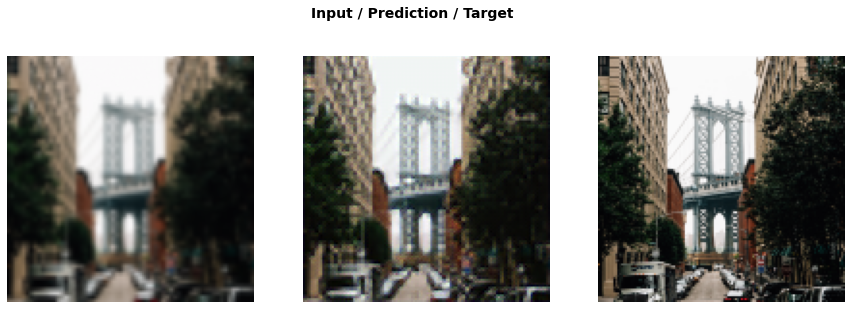

In [ ]:
do_fit('2a', lrs=slice(lr))

In [ ]:
learn_gen.unfreeze()

epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
0,39.183384,37.867496,22.094624,0.750780,0.090057,0.224790,0.796231,1.178379,0.674103,00:20
1,38.813641,37.636642,22.160156,0.754648,0.093170,0.219852,0.792888,1.172023,0.671240,00:20
2,38.692902,37.444313,22.168882,0.754740,0.091766,0.219494,0.791149,1.168782,0.669159,00:21
3,38.640583,37.355240,22.203358,0.754485,0.094326,0.219224,0.789532,1.166725,0.666494,00:20
4,38.584080,37.257500,22.200098,0.754986,0.094304,0.218333,0.788715,1.165049,0.665606,00:20
5,38.488960,37.231464,22.158520,0.753522,0.091562,0.220779,0.789943,1.166218,0.667347,00:20
6,38.444927,37.175877,22.154644,0.753941,0.090323,0.219236,0.789706,1.166045,0.667295,00:20
7,38.321320,37.157574,22.149935,0.753684,0.089811,0.220180,0.789396,1.165573,0.666907,00:19
8,38.222675,37.112186,22.149620,0.753562,0.089576,0.220007,0.788109,1.163559,0.665863,00:21
9,38.249306,37.113476,22.150215,0.753540,0.089896,0.219954,0.788415,1.163856,0.666229,00:20


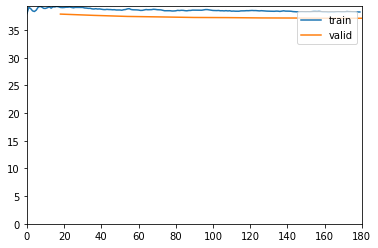

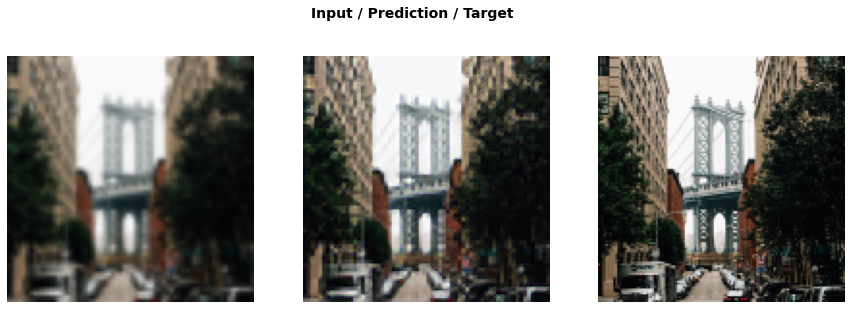

In [ ]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

### 128px →  256px

In [ ]:
data = get_data(256, bs=12)

In [ ]:
learn_gen.data = data
learn_gen.freeze()
gc.collect()

6825

In [ ]:
learn_gen.load('2b');

epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
0,21.385157,21.002436,23.457109,0.782380,0.089149,0.181651,0.702971,0.956543,0.511454,00:37
1,21.045364,21.130060,23.320847,0.776190,0.085188,0.190961,0.707674,0.963059,0.513978,00:29
2,21.199095,21.887548,23.044592,0.767596,0.086373,0.202879,0.717887,0.985032,0.522427,00:28
3,21.523064,22.031233,23.348066,0.778598,0.087605,0.195980,0.717839,0.985169,0.521504,00:29
4,21.902475,21.996819,23.176729,0.770779,0.088049,0.201655,0.718356,0.983139,0.519389,00:29
5,22.363295,22.038380,23.411655,0.778691,0.105055,0.191582,0.715426,0.973312,0.506492,00:29
6,22.408218,23.207352,23.265064,0.773542,0.107041,0.199092,0.728155,1.003112,0.522744,00:29
7,21.894316,21.210230,23.318769,0.777250,0.092289,0.193137,0.711419,0.967195,0.507982,00:29
8,21.712124,21.448315,23.125504,0.770520,0.087691,0.201233,0.712588,0.972754,0.511751,00:29
9,20.712305,19.829491,23.500473,0.782787,0.081317,0.181082,0.690641,0.935440,0.496977,00:29


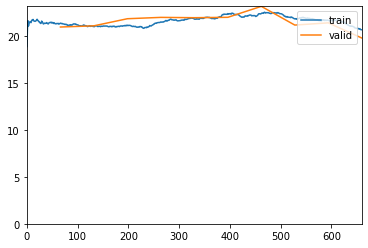

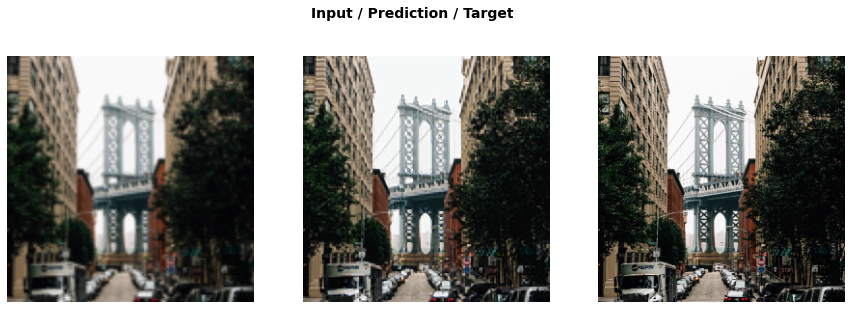

In [ ]:
do_fit('3a')

In [ ]:
learn_gen.unfreeze()

In [ ]:
#learn_gen.lr_find()
#learn_gen.recorder.plot()

epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
0,19.913961,19.761612,23.508772,0.783960,0.081376,0.180041,0.689611,0.933662,0.495542,00:30
1,19.830261,19.680386,23.548828,0.786636,0.083853,0.178104,0.686937,0.929111,0.491948,00:31
2,19.795471,19.576347,23.461973,0.783014,0.079693,0.180038,0.688527,0.931295,0.493451,00:29
3,19.725918,19.482008,23.435104,0.783429,0.079480,0.180501,0.688536,0.930022,0.493065,00:30
4,19.508509,19.494980,23.455784,0.783882,0.080590,0.179759,0.686834,0.927531,0.491073,00:30
5,19.435936,19.436655,23.448477,0.784059,0.080073,0.179536,0.686968,0.927621,0.491570,00:29
6,19.515850,19.438562,23.493792,0.785037,0.081758,0.178604,0.684625,0.924333,0.488904,00:30
7,19.466984,19.421616,23.485847,0.785215,0.081670,0.178627,0.685972,0.925380,0.490189,00:29
8,19.228159,19.379559,23.457975,0.783773,0.081218,0.179414,0.686337,0.925929,0.489925,00:29
9,19.341555,19.385212,23.454214,0.783767,0.080638,0.179449,0.686116,0.925561,0.490105,00:31


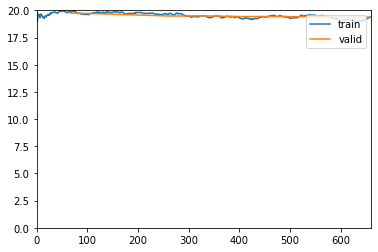

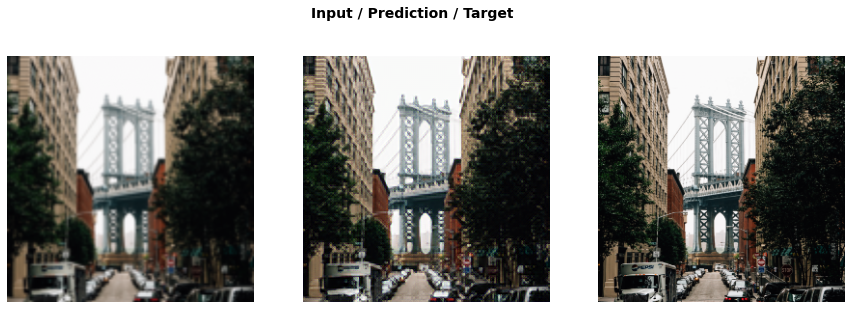

In [ ]:
do_fit('3b', slice(1e-6,1e-4), pct_start=0.3)

### 256px →  512px

In [ ]:
data = get_data(512, bs=2)

In [ ]:
learn_gen.data = data
learn_gen.freeze()
gc.collect()

7129

In [ ]:
learn_gen.load('3b');

In [ ]:
#learn_gen.lr_find()
#learn_gen.recorder.plot()

epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
0,11.863199,11.595951,25.800413,0.828671,0.079644,0.137701,0.611841,0.771014,0.362590,01:49
1,12.133248,11.890674,25.684259,0.825252,0.077193,0.142303,0.611188,0.775142,0.364514,01:46
2,12.505380,13.147297,25.496449,0.829822,0.093120,0.155804,0.619124,0.789733,0.365747,01:45
3,13.344036,12.876093,25.087210,0.821320,0.080651,0.167889,0.622429,0.792125,0.371912,01:46
4,13.309429,13.754037,24.684759,0.814142,0.100269,0.185148,0.637773,0.813648,0.377270,01:46
5,12.996867,13.300453,25.520849,0.828434,0.099669,0.152774,0.627123,0.799732,0.372288,01:46
6,13.387012,12.721539,25.896479,0.831164,0.098123,0.139802,0.614509,0.777905,0.360645,01:46
7,12.849058,12.981398,25.544195,0.824148,0.099706,0.150581,0.625534,0.791557,0.370044,01:46
8,12.964885,12.890083,25.353945,0.820080,0.101443,0.163925,0.625481,0.791585,0.374102,01:45
9,11.263241,11.387930,25.679602,0.828054,0.081872,0.138623,0.611145,0.767700,0.363955,01:46


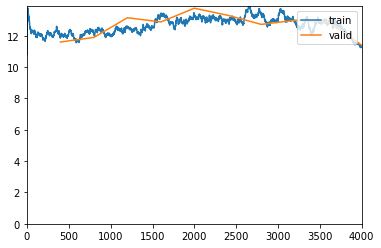

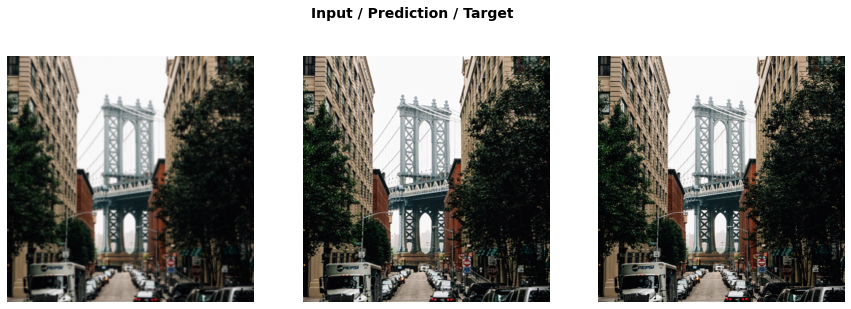

In [ ]:
do_fit('4a')

In [ ]:
learn_gen.unfreeze()

In [ ]:
#learn_gen.lr_find(1e-10, 1e-2)
#learn_gen.recorder.plot()

epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
0,11.414433,11.406875,25.839710,0.831026,0.085234,0.135861,0.605696,0.761189,0.360398,01:50
1,11.042504,11.379416,25.792953,0.829973,0.084180,0.136720,0.607214,0.762929,0.361191,01:51
2,11.551761,11.434009,25.836529,0.830923,0.085795,0.135927,0.605723,0.761340,0.359973,01:51
3,11.001016,11.340271,25.767483,0.829619,0.083638,0.137012,0.608771,0.764526,0.362709,01:52
4,11.473973,11.428101,25.838024,0.831176,0.085918,0.135818,0.606338,0.762081,0.360779,01:51
5,11.466834,11.377403,25.780319,0.829855,0.083769,0.136781,0.608326,0.764473,0.362300,01:50
6,11.359201,11.385567,25.835871,0.831002,0.086573,0.135870,0.606257,0.761572,0.359621,01:51
7,11.261873,11.476954,25.921562,0.831853,0.089414,0.134574,0.602866,0.757900,0.357556,01:51
8,11.333213,11.379592,25.774727,0.829922,0.083373,0.136813,0.608734,0.764860,0.363144,01:51
9,11.388658,11.363492,25.719002,0.828653,0.081956,0.137821,0.610091,0.766443,0.363638,01:51


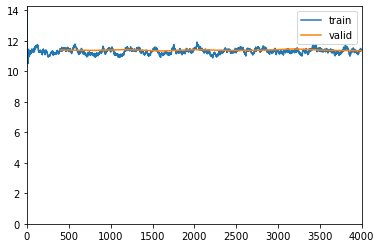

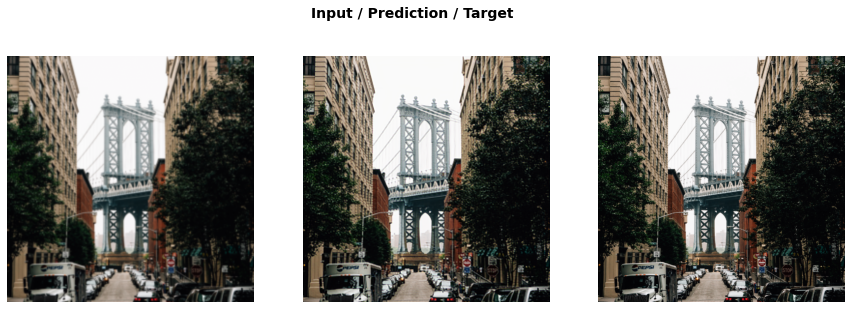

In [ ]:
do_fit('4b', slice(1e-8,1e-6), pct_start=0.3)

This might not be the limit, but it will be useful tu plug this model as a generator in a GAN. We'll need to pretrain a critic for that.

## Critic Pre-Training

In [ ]:
bs=8
sz=192

In [ ]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1
    
def save_gen_images():
    if path_gen.exists(): shutil.rmtree(path_gen)
    path_gen.mkdir(exist_ok=True)
    data_gen = get_data(bs=bs, y_size=sz, keep_pct=1.0)
    save_preds(data_gen.fix_dl)
    PIL.Image.open(path_gen.ls()[0])

In [ ]:
save_gen_images()

In [ ]:
old_checkpoint_num = 0
checkpoint_num = old_checkpoint_num + 1
gen_old_checkpoint_name = gen_name + '_' + str(old_checkpoint_num)
gen_new_checkpoint_name = gen_name + '_' + str(checkpoint_num)
crit_old_checkpoint_name = crit_name + '_' + str(old_checkpoint_num)
crit_new_checkpoint_name= crit_name + '_' + str(checkpoint_num)

In [ ]:
import pandas as pd
import numpy as np

def get_lr_hr_initial_df(size=128, scale=2):
    lr_path = generate_lr(size//scale)
    hr_path = generate_lr(size)
    return get_lr_hr_df(lr_path/"Train", hr_path/"Train")

def get_lr_hr_df(path_lr, path_hr):
    src_lr = ImageList.from_folder(path_lr)
    src_hr = ImageList.from_folder(path_hr)
    count_lr = len(src_lr)
    count_hr = len(src_hr)
    src = src_lr.add(src_hr)
    
    items = src.items
    labels = np.array(['LR']*count_lr + ['HR']*count_hr)

    num_valid = int(len(items)*0.1)
    is_valid = np.zeros(len(items), dtype=int)
    is_valid[:num_valid] = 1
    np.random.shuffle(is_valid)
    is_valid = is_valid.astype(bool)

    df = pd.DataFrame()
    df['name'] = src.items
    df['label'] = labels
    df['is_valid'] = is_valid
    return df

df = get_lr_hr_initial_df(size=128, scale=4)
df.iloc[[10,1000]]

NameError: name 'generate_lr' is not defined

In [ ]:
def get_crit_initial_data(bs, size, scale=2, add_transforms = True)->ImageDataBunch:
    df = get_lr_hr_initial_df(size=size, scale=scale)
    tfms = get_transforms(
                   max_zoom=1.2, max_lighting=0.5, max_warp=0.25
               ) if add_transforms else []
    data = ImageDataBunch.from_df('.', df, 
                                  bs=bs, size=size,
                                  ds_tfms = tfms,  
                                 ).normalize(imagenet_stats)
    return data

def get_crit_data(folder_gen, folder_hr, bs, size, add_transforms = True)->ImageDataBunch:
    df = get_lr_hr_df(path_lr=path_dataset/folder_gen,
                 path_hr=path_dataset/folder_hr)
    tfms = get_transforms(max_zoom=1) if add_transforms else []
    data = ImageDataBunch.from_df('.', df, 
                                  bs=bs, size=size,
                                  ds_tfms = tfms,  
                                 ).normalize(imagenet_stats)
    return data

In [ ]:
from sisr_thesis.critic import *
learn_critic = critic_learner(get_crit_data(name_gen, 'images/Train', bs=bs, size=size))

Pretraining with LR and HR pairs.

Fine tuning with generator output.

In [ ]:
# from fastai.vision.gan import *
# def critic_learner(
#     data: ImageDataBunch,
#     loss_critic=AdaptiveLoss(nn.BCEWithLogitsLoss()),
#     nf: int = 256,
# ) -> Learner:
#     return Learner(
#         data,
#         gan_critic(),
#         metrics=accuracy_thresh_expand,
#         loss_func=loss_critic,
#         callback_fns=[ShowGraph],
#         wd=1e-3,
#     )
#     learner.path = path_dataset
#     return learner

In [ ]:
writer = SummaryWriter(log_dir = TENSORBOARD_PATH/'CriticPre')

In [ ]:
if old_checkpoint_num == 0:
    bs=32
    sz=128
    learn_gen=None
    gc.collect()
    
    # initial data 
    data_crit = get_crit_initial_data(bs=bs, size=sz, scale=2)
    data_crit.show_batch(rows=2, ds_type=DatasetType.Train, imgsize=3)
    
    learn_critic = critic_learner(data=data_crit)      
    
    # callbacks
    tb_cb = LearnerTensorboardWriter(learn_critic, writer)
    csv_logger = CsvLoggerEx(learn_critic, 'critic_pretraining_history.csv', True)

    # LR vs. HR (scale 2)
    learn_critic.fit_one_cycle(10, 1e-3, callbacks=[tb_cb, csv_logger])
    
    # refinement Gen vs. HR
    data_crit = get_crit_data(name_gen, 'images/Train', bs=bs, size=size)
    data_crit.show_batch(rows=2, ds_type=DatasetType.Train, imgsize=3)
    learn_critic.data = data_crit
    learn_critic.fit_one_cycle(20, 1e-3, callbacks=[tb_cb, csv_logger])
    learn_critic.path = path_dataset
    learn_critic.save(crit_old_checkpoint_name)

In [ ]:
bs=16
size=192

In [ ]:
data_crit = get_crit_data(name_gen, 'images/Train', bs=bs, size=size)
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [ ]:
learn_critic = critic_learner(data=data_crit)
learn_critic.path = path_dataset
learn_critic.load(crit_old_checkpoint_name, with_opt=False);

In [ ]:
learn_critic.fit_one_cycle(6, 1e-4)

In [ ]:
learn_critic.fit_one_cycle(4, 1e-4)

In [ ]:
learn_critic.save(crit_new_checkpoint_name)

## GAN training

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()

In [ ]:
lr=1e-5
size=192
bs=9

In [ ]:
data_crit = get_crit_data(name_gen, 'images/Train', bs=bs, size=size)

In [ ]:
learn_critic = critic_learner(data=data_crit)
learn_critic.path = path_dataset
learn_critic.load(crit_new_checkpoint_name, with_opt=False);

In [ ]:
learn_gen = create_generator_learner(data)
learn_gen.path = path_dataset
learn_gen.load('4b', with_opt=False);

In [ ]:
def get_orig(path_lr):
    return path_hr/path_lr.parent.parts[-1]/path_lr.name

def get_orig_idx(idx:int):
    return get_orig(learn_gen.data.valid_ds.x.items[idx])

def resize_keep_ar(img, max_size = 1024):
    img = open_image(get_orig_idx(0));
    w,h = img.shape[1], img.shape[2]
    rw = max_size / w
    rh = max_size / h
    rmin = min(rw,rh)
    w = int(round(w * rmin))
    h = int(round(h * rmin))
    return img.resize((img.shape[0], w, h)).refresh()

def image_for_prediction(idx:int):
    img = open_image(get_orig_idx(idx));
    img_lr = crappify(img, 512)
    img_lr = resize_keep_ar(img_lr, 1024)
    return img_lr


In [ ]:
from fastai.basic_train import Learner, LearnerCallback
from fastai.vision.gan import GANLearner


class GANSaveCallback(LearnerCallback):
    """A `LearnerCallback` that saves history of metrics while training `learn` into CSV `filename`."""

    def __init__(
        self,
        learn: GANLearner,
        learn_gen: Learner,
        filename: str,
        save_epochs: int = 5,
    ):
        super().__init__(learn)
        self.learn_gen = learn_gen
        self.filename = filename
        self.save_epochs = save_epochs
        self.epochs = 0

    def on_epoch_end(self, iteration: int, epoch: int, **kwargs) -> None:
        self.epochs += 1
        if self.epochs % self.save_epochs == 0:
            self._save_gen_learner(epoch=epoch)

    def _save_gen_learner(self, epoch: int):
        filename = '{}_ep{}'.format(self.filename, epoch)
        self.learn_gen.save(filename)

In [ ]:
writer = SummaryWriter(log_dir = TENSORBOARD_PATH/'GanLearner')

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_critic, weights_gen=(1.0,2.0), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.9)), wd=1e-3, metrics=metrics)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
learn.callback_fns.append(partial(GANTensorboardWriter, tbwriter=writer, visual_iters=100))
learn.callback_fns.append(partial(GANSaveCallback, learn_gen=learn_gen, filename=gen_new_checkpoint_name, save_epochs=5))

In [ ]:
learn.data = get_data(y_size=size, bs=bs)
#learn_gen.freeze_to(-1)
learn.fit(100,lr, callbacks=[save_img_cb])

# Test (simple)

In [ ]:
learn_gen = None
learn_crit = None
gc.collect();

In [ ]:
torch.cuda.empty_cache()

In [ ]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

In [ ]:
learn_gen = create_generator_learner(data)
learn_gen.path = path_dataset

In [ ]:
learn_gen.load('4b');

In [ ]:
learn_gen.load('with_GAN_0-gen_1_39_3500');

In [ ]:
learn_gen.data = get_data(1024,1)

In [ ]:
filename = learn_gen.data.valid_ds.x.items[0]; filename

In [ ]:
def get_orig(path_lr):
    return path_hr/path_lr.parent.parts[-1]/path_lr.name

def get_orig_idx(idx:int):
    return get_orig(learn_gen.data.valid_ds.x.items[idx])

open_image(get_orig_idx(0));
open_image(get_orig_idx(1));
open_image(get_orig_idx(2));


In [ ]:
def get_orig(path_lr):
    return path_hr/path_lr.parent.parts[-1]/path_lr.name
img_orig = open_image(get_orig(filename)); img_orig.shape
img_orig.resize((3, 512*2, 770*2)).refresh()
img_orig.shape

In [ ]:
img = open_image(filename); img.shape

In [ ]:
learn_gen.data.single_ds.tfmargs['size'] = [img.shape[1]*2,img.shape[2]*2]

In [ ]:
p,img_hr,b = learn_gen.predict(img)

In [ ]:
img_hr.shape

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [ ]:
show_image(img_hr.clamp(min=0,max=1), figsize=(18,15))

In [ ]:
show_image(img_orig, figsize=(18,15))